<a href="https://colab.research.google.com/github/mentalinvestor/qae_r/blob/main/Part_6_%EB%8B%A4%EC%96%91%ED%95%9C_%EC%8B%9C%EA%B3%84%EC%97%B4_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%8B%A4%EC%8A%B5%ED%95%98%EA%B8%B0_(%EC%88%98%EA%B0%95%EC%83%9D%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Part 6. 다양한 시계열 프로젝트 실습하기</b>

## 실습 가이드
1. 데이터를 다운로드하여 Colab에 불러옵니다.
2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
3. 코드는 위에서부터 아래로 순서대로 실행합니다.
4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## <b> Ch 1. Part 6 학습목표</b>

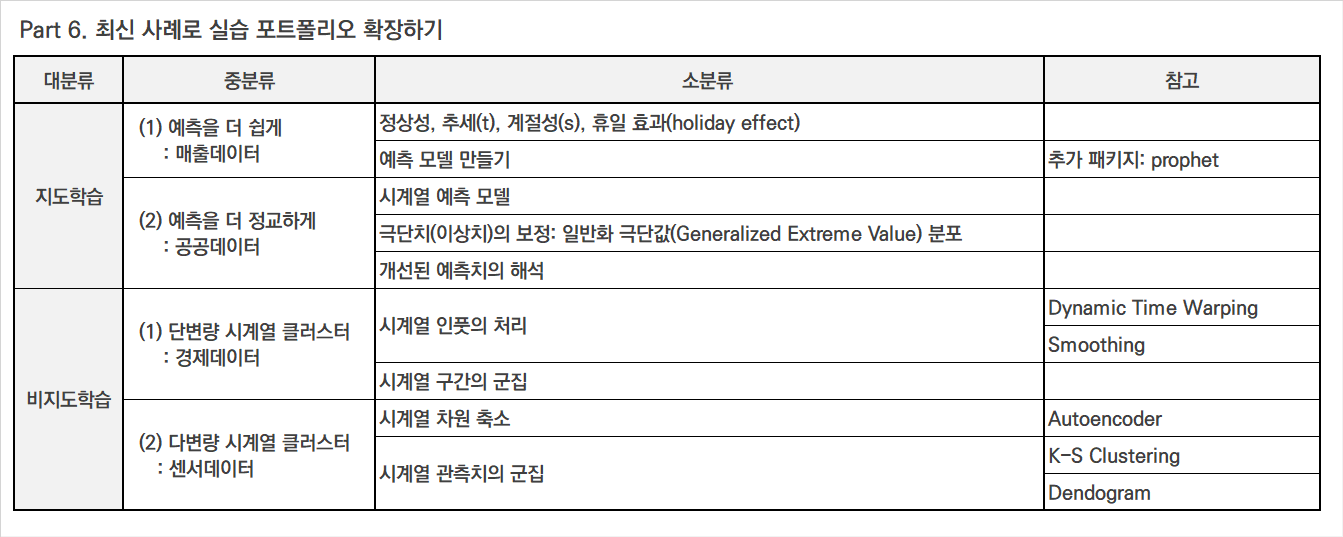

## <b>Ch 2. 지도학습(1): 예측을 더 쉽게 </b>



### 실습의 주안점 및 매출 데이터 소개

In [ ]:
# Sales record for every product and store for Russian Software company 1C

### 계절성 있는 시계열 분석으로 미래 매출 내다보기

In [ ]:
import numpy as np
import pandas as pd  
import random as rd  
import datetime 
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")

In [ ]:
filepath = 'https://github.com/mchoimis/tsdl/raw/main/sales/'
sales = pd.read_csv(filepath + 'train.csv') 
item_cat = pd.read_csv(filepath + 'item-category.csv')
item = pd.read_csv(filepath + 'items.csv')
shops = pd.read_csv(filepath + 'shops.csv')
test = pd.read_csv(filepath + 'test.csv')

In [ ]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y')) # UDF로 time index 만들기
print(sales.info())

In [ ]:
sales.head()

In [ ]:
sales.head(10)

In [ ]:
sales.tail()

In [ ]:
# Aggregate to monthly level

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [ ]:
# See monthly sales record
monthly_sales.head(20)

In [ ]:
# Number of items per category
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x

In [ ]:
# Visualize # Cross-sectional
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [ ]:
# Make time series
ts=sales.groupby(["date"])["item_cnt_day"].sum()
ts.astype('float')
ts

In [ ]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.xlabel('Time - Date Blocks')
plt.ylabel('Sales')
plt.title('Total Sales')
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()
plt.show()

In [ ]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
plt.figure(figsize=(16,12))
fig = res.plot()
plt.show()

In [ ]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [ ]:
# Testing for Stationarity
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

In [ ]:
# Remove Trend (t) component
from pandas import Series as Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [ ]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

plt.figure(figsize=(16,16))

plt.subplot(311)
plt.title('Original')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After Decomposition - Trend (t)')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After Decomposition - Seasonality (s)')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [ ]:
# Testing for stationarity after decomposition
test_stationarity(new_ts)

### 심화 Point: Prophet 패키지 이용하여 수요 예측하기

In [ ]:
from prophet import Prophet

In [ ]:
# Make inout data for Prophet 

In [ ]:
# Add dates to Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS') # Month Start
ts=ts.reset_index()
ts.head()

In [ ]:
ts.columns=['ds','y']

In [ ]:
# model = Prophet(model_params)
model = Prophet(yearly_seasonality=True)  # Intantiate the model

In [ ]:
# Prophet params
# Example

# growth(values = c("linear", "logistic"))

# changepoint_num(range = c(10L, 50L), trans = NULL)
# changepoint_range(range = c(0.6, 0.9), trans = NULL)

# seasonality_yearly(values = c(TRUE, FALSE))
# seasonality_weekly(values = c(TRUE, FALSE))
# seasonality_daily(values = c(TRUE, FALSE))

# prior_scale_changepoints(range = c(-3, 2), trans = log10_trans())
# prior_scale_seasonality(range = c(-3, 2), trans = log10_trans())
# prior_scale_holidays(range = c(-3, 2), trans = log10_trans())

In [ ]:
model = Prophet(yearly_seasonality=True) # Prophet object can only be fit once. Instantiate a new object when running multiple times
model.fit(ts) # fit the model 

### 분석결과

In [ ]:
# Predict for five months in the furure
future = model.make_future_dataframe(periods = 5, freq = 'MS')  # MS - month start
forecast = model.predict(future)

In [ ]:
forecast.head()

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
model.plot(forecast)

In [ ]:
# plot the model forecast chart with component charts in trend and seasonality  
model.plot_components(forecast)

In [ ]:
# Show all forecasting values in a table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

## <b> Ch 3. 지도학습(2): 예측을 더 정교하게</b>


### 공공 데이터 소개

In [ ]:
# https://opendata.vancouver.ca/pages/home/

In [ ]:
자연재해나 위기와 같은 극단치 포함 데이터: 범죄율, 강수량, 지진, 교통사고, 코로나
금융위기, 정치위기 
특정일(event) 발생시 트래픽이 갑자기 증가하는 경우
프로모션 등의 이벤트 발생시 재고수준, 수요, 매출 등의 예측

### LSTM으로 범죄 예방하기

In [ ]:
! pip install keras-hypetune # 케라스 그리드 서치
! pip install fitter # GEV 분포 생성

In [ ]:
import os
import random
import warnings
import numpy as np
from scipy import stats
from fitter import Fitter
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasGridSearch

In [ ]:
## Read data

filepath = 'https://github.com/mchoimis/tsdl/raw/main/crime/crime.csv'
df = pd.read_csv(filepath)
df['Date'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

df = pd.DataFrame({'n_crimes':df.Date.value_counts().sort_index()})
df['month'] = df.index.month
df['wday'] = df.index.dayofweek
df['day'] = df.index.day

df.info()

In [ ]:
print(df.head())

In [ ]:
print(df.tail())

In [ ]:
## Plot aggregated daily crimes

df.n_crimes.plot(figsize=(16,8))
plt.ylabel('Daily # of Crimes')
plt.show()

In [ ]:
## Plot seasonality  

plt.figure(figsize=(16,6))

plt.subplot(121)
df.n_crimes.groupby(df.index.month).median().rename('Median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('Aggregate # of Crimes'); plt.xlabel('Month')

plt.subplot(122)
df.n_crimes.groupby(df.index.weekday).median().rename('Median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('Aggregate # of Crimes'); plt.xlabel('Weekday')

plt.show()

In [ ]:
## Define utility functions

def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)


class Scaler3D:
    
    def fit(self, X):
        self.mean = X.reshape(-1,X.shape[-1]).mean(0).reshape(1,1,-1)
        self.std = X.reshape(-1,X.shape[-1]).std(0).reshape(1,1,-1)
        return self
        
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X):
        return (X * self.std) + self.mean

    
def prepare_seq(num_X, cat1_X, cat2_X, scaler=None):
    
    if scaler is not None:
        num_X = scaler.transform(num_X)
        
    inp_dict = {}
    inp_dict['inp_num'] = num_X
    for i,c in enumerate(cat_var):
        inp_dict[f"inp_{c}_cat1"] = cat1_X[:,:,i]
        inp_dict[f"inp_{c}_cat2"] = cat2_X[:,:,i]
    
    return inp_dict

In [ ]:
### Split train & test, apply scaler

time_h = 7
window_shape = 21

target = ['n_crimes']
cat_var = ['month','wday','day']

_id_train, _id_valid = train_test_split(np.arange((len(df) - window_shape - time_h + 1)), test_size=0.3, shuffle=False)

_num_X = create_windows(df[target], window_shape=window_shape, end_id=-time_h)
_cat1_X = create_windows(df[cat_var], window_shape=window_shape, end_id=-time_h)
_cat2_X = create_windows(df[cat_var], window_shape=time_h, start_id=window_shape)
_target = create_windows(df[target], window_shape=time_h, start_id=window_shape)

_num_X_train = _num_X[_id_train]; _num_X_valid = _num_X[_id_valid]
_cat1_X_train = _cat1_X[_id_train]; _cat1_X_valid = _cat1_X[_id_valid]
_cat2_X_train = _cat2_X[_id_train]; _cat2_X_valid = _cat2_X[_id_valid]
_target_train = _target[_id_train]; _target_valid = _target[_id_valid]

X_scaler = Scaler3D().fit(_num_X_train)
y_scaler = Scaler3D().fit(_target_train)

X_train = prepare_seq(_num_X_train, _cat1_X_train, _cat2_X_train, scaler=X_scaler)
y_train = y_scaler.transform(_target_train)
X_valid = prepare_seq(_num_X_valid, _cat1_X_valid, _cat2_X_valid, scaler=X_scaler)
y_valid = y_scaler.transform(_target_valid)

In [ ]:
### Define Model  

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):
    
    set_seed(33)
    
    inp_num = Input((window_shape,1), name='inp_num')
    
    embeddings = {
        'month': Embedding(12+1, param['emb_dim']),
        'wday': Embedding(6+1, param['emb_dim']),
        'day': Embedding(31+1, param['emb_dim'])
    }
    
    inp_cat1, emb_cat = [], []
    for c in cat_var:
        _inp_c1 = Input((window_shape,), name=f"inp_{c}_cat1")
        emb = embeddings[c](_inp_c1)
        inp_cat1.append(_inp_c1)
        emb_cat.append(emb)
    
    enc = Concatenate()([inp_num] + emb_cat)
    enc = LSTM(param['lstm_unit'], return_sequences=False)(enc)
    
    inp_cat2, emb_future = [], []
    for c in cat_var:
        _inp_c2 = Input((time_h,), name=f"inp_{c}_cat2")
        emb = embeddings[c](_inp_c2)
        inp_cat2.append(_inp_c2)
        emb_future.append(emb) 
    
    x = RepeatVector(time_h)(enc)
    dec = Concatenate()([x] + emb_future)
    dec = LSTM(param['lstm_unit'], return_sequences=True)(dec)
    
    output = TimeDistributed(Dense(1))(dec)
    
    model = Model([inp_num] + inp_cat1 + inp_cat2, output)
    model.compile(Adam(lr=param['lr']), 'mse')
    
    return model

In [ ]:
## Modeling Fitting  

param_grid = {
    'lstm_unit': [128,64,32], 
    'emb_dim': [8,16,32],
    'lr': [1e-4,1e-3], ## learning rate
    'epochs': 100, 
    'batch_size': 64
}

es = EarlyStopping(patience=7, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es])

In [ ]:
print('BEST PARAM:', kgs.best_params)

In [ ]:
## Get predicted values 

pred = np.squeeze(
    y_scaler.inverse_transform(
        kgs.best_model.predict(X_valid)
    ), -1)

y_valid = np.squeeze(y_scaler.inverse_transform(y_valid), -1)

In [ ]:
## Visualize Test vs Predicted 
## Test vs prediction values are on different time horizons

plt.figure(figsize=(18,8))

for t_h in range(time_h):
    plt.plot(pred[(time_h-t_h):-(t_h+1),t_h], 
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"Pred day + {t_h+1}")

plt.plot(y_valid[time_h:,0], c='red', alpha=0.4, label='Actual')

plt.ylabel('Daily # of Crimes: Actual vs Predicted')
plt.xlabel('Time')
plt.legend()
plt.show()

In [ ]:
## Get model and baseline mse

mse_model = {}
mse_baseline = {}
    
for t_h in range(time_h):

    _mse = mse(y_valid[1:,t_h], y_valid[:-1,0])
    mse_baseline[f"day + {t_h+1}"] = _mse 

    _mse = mse(y_valid[:,t_h], pred[:,t_h])
    mse_model[f"day + {t_h+1}"] = _mse 

In [ ]:
## Plot MSEs 
## MSEs are computed on different time horizons 

plt.figure(figsize=(14,5))

plt.bar(np.arange(len(mse_model))-0.15, mse_model.values(), alpha=0.5, width=0.3, label='Seq2Seq')
plt.bar(np.arange(len(mse_baseline))+0.15, mse_baseline.values(), alpha=0.5, width=0.3, label='Baseline')
plt.xticks(range(len(mse_baseline)), mse_baseline.keys())
plt.ylabel('MSE')
plt.legend()
plt.show()

### 심화 Point: 일반화 극단값(GEV) 분포로 이상치가 높은 시계열 예측값 개선하기

In [ ]:
# Extreme Value 적용하기

In [ ]:
## Get residuals

t_h = 1 # desired time forecasting horizon to compute the EVA

resid = np.abs(y_valid[:,t_h] - pred[:,t_h])
data = pd.Series(resid, index=(df.iloc[_id_valid[0]:_id_valid[-1]+1]).index, name='resid')

In [ ]:
## Plot block maxima

plt.figure(figsize=(16,8))

plt.subplot(121)
data.plot(ax=plt.gca(), alpha=0.5)
plt.scatter(data[data.resample('1M').apply(lambda x: x.idxmax()).values].index, 
            data[data.resample('1M').apply(lambda x: x.idxmax()).values].values, c='red')
plt.ylabel('Residuals')

plt.subplot(122)
data = data.resample('1M').max()
data.plot(ax=plt.gca(), c='red')
plt.ylabel('Residuals')
plt.show()

In [ ]:
## Utiliy functions to create bootstrap

def bootstrap_ci(
    data, 
    statfunction=np.average, 
    alpha = 0.05, 
    n_samples = 100):

    def bootstrap_ids(data, n_samples=100):
        for _ in range(n_samples):
            yield np.random.randint(data.shape[0], size=(data.shape[0],))    
    
    alphas = np.array([alpha/2, 1 - alpha/2])
    nvals = np.round((n_samples - 1) * alphas).astype(int)
    # if np.any(nvals < 10) or np.any(nvals >= n_samples-10):
    #     warnings.warn("Some values used extremal samples; results are probably unstable. "
    #                   "Try to increase n_samples")

    data = np.array(data)
    # if np.prod(data.shape) != max(data.shape):
    #     raise ValueError("Data must be 1D")
    data = data.ravel()
    
    boot_indexes = bootstrap_ids(data, n_samples)
    stat = np.asarray([statfunction(data[_ids]) for _ids in boot_indexes])
    stat.sort(axis=0)

    return stat[nvals]

In [ ]:
## Get distribution for exreme residuals

f = Fitter(data, distributions=['genextreme','gumbel_r'], bins=20) # 일반화 극단분포(GEV), Gumbel 분포
f.fit()

In [ ]:
## Plot distribution for extreme residuals
plt.figure(figsize=(10,6))
f.summary()
plt.title('Empirical vs Estimated Distributions of Extreme Values')
plt.show()

In [ ]:
best_dist = eval(f"stats.{list(f.get_best().keys())[0]}")
f.get_best() # c가 0에 가깝다

In [ ]:
## Get estimated params from the best distribution

best_params = best_dist.fit(data)
best_params

In [ ]:
## Calculate bootstrap intervals for the estimted best params

np.random.seed(111)
ci_params = bootstrap_ci(data, best_dist.fit, n_samples=500)
ci_params

In [ ]:
## Define return periods (재현기간) & estimted return values (재현값) 

eps = 1e-1
T = np.arange(1, 1000, eps) + eps # return periods
q = 1-1/T
ppf = best_dist.ppf(q, *best_params) # return values

In [ ]:
## Calculate bootstrap intervals for the estimted return values

def gen_ppf(data, q):
    
    new_param = best_dist.fit(data)
    ppf = best_dist.ppf(q, *new_param)
    
    return ppf

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)
ci_ppf

### 분석결과 및 해석

In [ ]:
## Plot return values (재현값) 

plt.figure(figsize=(18,8))

plt.semilogx(T, ppf, c='b')
plt.semilogx(T, ci_ppf[0], c='b', linestyle='--')
plt.semilogx(T, ci_ppf[1], c='b', linestyle='--')

N = np.arange(1, len(data)+1)
plt.scatter(N[-1]/N, sorted(data)[::-1], color = 'red')
plt.ylabel('Return values')
plt.xlabel('Return periods (log scale)')
plt.show()

In [ ]:
## Create a summary

eps = 1e-1
T = np.asarray([1, 2, 5, 10, 25, 50, 100]) + eps
q = 1-1/T
ppf = best_dist.ppf(q, *best_params)

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)

summary = pd.DataFrame({
    'return_period':(T-eps).astype(int),
    'lower_ci':ci_ppf[0], 
    'return_value':ppf, 
    'upper_ci':ci_ppf[-1]
}).set_index('return_period')

summary

## <b>Ch 4. 비지도학습(1): 단변량 시계열 클러스터링</b>



### 경제 데이터 소개

In [ ]:
! pip install tsmoothie # 시계열 관측치 스무딩

In [ ]:
! pip install tslearn # DTW 이용한 시계열 클러스터링

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tsmoothie.smoother import *
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
import warnings
warnings.simplefilter('ignore')

In [ ]:
## Read data

filename = 'https://github.com/mchoimis/tsdl/raw/main/macro/stock.csv'
df = pd.read_csv(filename, index_col=0)

In [ ]:
df.info()

In [ ]:
df.head()

,stock,timestamp,open,high,low,adj_close,volume
0,GERN,1532988000,3.34,3.59,3.59,3.59,4650479
1,GERN,1532901600,3.36,3.45,3.45,3.30,3571600
2,GERN,1532642400,3.44,3.50,3.50,3.34,2928697
3,GERN,1532556000,3.26,3.56,3.56,3.44,4209642
4,GERN,1532469600,3.37,3.42,3.42,3.22,3568900


In [ ]:
df.head() # timestamp corrected

In [ ]:
df.tail()

In [ ]:
# Make timestamp datetime
df['timestamp'] = df.timestamp.apply(datetime.fromtimestamp)
df = df.loc[df.timestamp.dt.year > 2014].copy()
df.sort_values(['stock','timestamp'], inplace=True)

In [ ]:
### View Close Price Series unstacked

df_close = df.set_index(['stock','timestamp'])['adj_close'].unstack()  ##
df_close = df_close.loc[~df_close.isna().any(axis=1)].copy()
df_close.columns = range(len(df_close.columns))
df_close.head(10)

### 심화 Point: 시계열 비지도학습의 유의점과 해석방법

<b>참고: 군집화(클러스터링) 알고리즘</b>
- k-means Clustering
  - 파라미터: k
- Agglomerative Clustering (병합군집)
  - 파라미터: eps

<b> 일반적인 벡터의 유사도 측정</b>
* 유클리드 거리(Euclidean distanc 또는 L2 distance) 

- 장점
  - 계산이 용이하고 연산속도가 빠르다

- 단점
  - 동일한 시간 구간끼리 비교하게 되면, 신호의 떨림과 움직임이 심해질수록 어긋나게 됨
  - 길이가 다른 시계열 분석 불가


<b> DTW(동적 시간 워핑)을 이용한 시계열 유사도 측정</b>
- 장점
  - 서로 다른 길이의 시계열 유사도 분석 가능
  - 다차원 시계열 데이터의 분석 가능 

- 단점
  - 연산비용이 크다

### 움직임이 유사한 시계열 구간 클러스터 찾기

<b> 참고: scikit-learn에서 제공하는 피처 스케일러(scaler)</b>

- `StandardScaler`: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- `RobustScaler`: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- `MinMaxScaler`: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- `Normalizer`: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

<p> 스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문입니다. 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 합니다.
    
<p> 반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있습니다. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있습니다. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있습니다.
    
<p> 스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것입니다. 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있습니다. 이 점을 함께 고려하시면 좋겠습니다.

In [ ]:
## Smooth price series

window_shape = 20

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), window_shape=window_shape)
smoother.smooth(df_close.loc['AMZN'])

low, up = smoother.get_intervals('prediction_interval') # only for visualization

In [ ]:
## Scale price series - raw data 

raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)
raw_scaled.shape # 몇차원

In [ ]:
raw_scaled

In [ ]:
## Make clusters using raw price series
## DTW(Dynamic Time Warping)

kmeans_raw = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=123) ###
kmeans_raw.fit(raw_scaled)

In [ ]:
kmeans_raw.labels_

In [ ]:
kmeans_raw.cluster_centers_

In [ ]:
### Visualize price series clusters

colors = {0:'orange',1:'green',2:'blue',3:'red'}

for c in range(kmeans_raw.n_clusters):    
    plt.plot(np.squeeze(raw_scaled[kmeans_raw.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_raw.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"Time Series Cluster #{c}")
    plt.show()

In [ ]:
## Make clusters using raw price series with different random seed

kmeans_raw_1234 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=1234) ###
kmeans_raw_1234.fit(raw_scaled)

In [ ]:
## Plot cluster samples

colors = {0:'orange',1:'green',2:'blue',3:'red'}

for c in range(kmeans_raw_1234.n_clusters):
    plt.plot(np.squeeze(raw_scaled[kmeans_raw_1234.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_raw_1234.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    plt.show()

In [ ]:
### Visualize price series clusters

plt.figure(figsize=(16,8))
plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in kmeans_raw.labels_])
plt.xticks(range(0,len(df.timestamp.unique())-window_shape, 100), 
           df.timestamp[window_shape::100].dt.date.unique())
plt.ylabel('AMZN Price')
plt.title("Time Series Clustering - Phase Detection in Stock Market (Raw)")
plt.show()

### 분석결과 및 해석

<b>참고: Lowess 평활화 (Lowess Smoothing) </b> 

Locally Weighted Scatterplot Smoothing

In [ ]:
## Smooth price series

window_shape = 20

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), window_shape=window_shape)
smoother.smooth(df_close.loc['AMZN'])

low, up = smoother.get_intervals('prediction_interval') # only for visualization

In [ ]:
### Plot the first 12 smoothed windows

plt.figure(figsize=(18,12))

for i,(true,smooth) in enumerate(zip(smoother.Smoother.data, smoother.Smoother.smooth_data)):
    
    if i == 12:
        break
    
    plt.subplot(3,4, i+1)
    plt.plot(smooth, linewidth=3, color='blue')
    plt.plot(true, '.k')
    plt.fill_between(range(len(true)), low[i], up[i], alpha=0.3)
    plt.title(f"window {i}")

In [ ]:
## Scale smoothed series

smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
smooth_scaled.shape

In [ ]:
## Make clusteres using smoothed series

kmeans_sm = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
kmeans_sm.fit(smooth_scaled)

In [ ]:
## Plot clusters

colors = {0:'red',1:'blue',2:'orange',3:'green'}

for c in range(kmeans_sm.n_clusters):
    
    plt.plot(np.squeeze(smooth_scaled[kmeans_sm.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_sm.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

In [ ]:
## Plot Clusters 

plt.figure(figsize=(16,8))

plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in kmeans_sm.labels_])

plt.xticks(range(0,len(df.timestamp.unique())-window_shape, 100), 
           df.timestamp.dt.date.unique()[window_shape::100])
plt.ylabel('AMZN Price')
plt.title('Time Series Clustering - Phase Detection in Stock Market (After Smoothing)')
plt.show()

## <b>Ch 5. 비지도학습(2): 다변량 시계열 클러스터링</b>

### 실습의 주안점 및 센서 데이터 소개

### 모빌리티 센서 데이터의 활동 분류

In [ ]:
import os
import io
import gzip
import pickle
import random
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from scipy import stats
import scipy.cluster.hierarchy as sch

In [ ]:
# 미리 구축한 인풋 데이터 다운로드 받기
datapath = 'https://github.com/mchoimis/tsdl/raw/main/motion/'

In [ ]:
# 모델 데이터를 업로드할 구글 드라이브와 코랩을 연동하기

from google.colab import drive
drive.mount('/content/gdrive')

## 실행 후 나오는 URL 주소에 가서 로그인을 해주세요.
## 로그인을 하셨다면 나오는 페이지에서 허용(Allow)을 눌러주세요.
## 생성된 authorization code 복사 후 코랩 창으로 돌아와 붙여넣으세요.
## Mounted at /content/gdrive (혹은 지정한 폴더 위치) 라는 메시지가 뜨면 마운트가 완료된 것입니다. 다음으로 넘어가주세요.

In [ ]:
# Get Present Working Directory
! pwd

In [ ]:
# Create new folder
! mkdir motion
# 저장해둔 모델 아웃풋과 데이터를 구글 드라이브에 Drag & Drop 방식으로 업로드해주세요.

In [ ]:
cd /content/motion

In [ ]:
! ls

In [ ]:
# 저장한 데이터와 모델 불러오기

with gzip.open('/content/motion/data.pickle','rb') as f:
    data =  pickle.load(f)
    
with gzip.open('/content/motion/person_id.pickle','rb') as f:
    person_id =  pickle.load(f)

In [ ]:
print(np.array(data).shape)
print(np.array(person_id).shape)

In [ ]:
list(data)

In [ ]:
person_id

In [ ]:
plt.plot(data[11])
plt.legend(['X','Y','Z'])
plt.title(person_id[11]); plt.xlabel('Time')

In [ ]:
data = np.asarray(data)

In [ ]:
data

In [ ]:
## Standardize 

for i,s in enumerate(data):
    data[i] = (data[i] - s.mean(axis=0)) / s.std(axis=0)

### 심화 Point: 다차원 시계열 클러스터링

In [ ]:
# Dimensionality Reduction

In [ ]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_autoencoder(data):
    
    set_seed(33)

    input_layer = Input(shape=(data.shape[1], data.shape[2]))
    
    encoder = TimeDistributed(Dense(200, activation='tanh'))(input_layer)
    encoder = TimeDistributed(Dense(50, activation='tanh'))(encoder)
    latent = TimeDistributed(Dense(10, activation='tanh'))(encoder)
    decoder = TimeDistributed(Dense(50, activation='tanh'))(latent)
    decoder = TimeDistributed(Dense(200, activation='tanh'))(decoder)

    out = TimeDistributed(Dense(data.shape[2]))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [ ]:
autoencoder = get_autoencoder(data)
autoencoder.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=0)

autoencoder = get_autoencoder(data)
autoencoder.fit(data[:10],data[:10], epochs=200, verbose=2, validation_data=(data[:10],data[:10]), callbacks=[es])

In [ ]:
predictions = autoencoder.predict(data[[11]])
mse = np.mean(np.power(data[[11]] - predictions, 2), axis=2)

plt.figure(figsize=(16,6))
plt.scatter(range(data.shape[1]), mse)
plt.xlabel('time')
plt.ylabel('mse')
plt.title('reconstruction error '+person_id[11])

### 분석결과

In [ ]:
# Pearson Correlation CLUSTERING

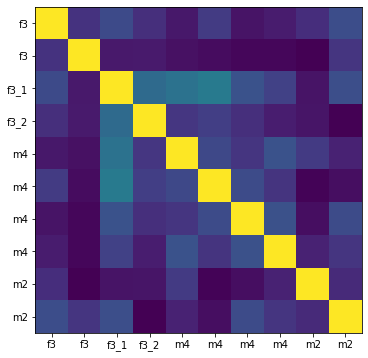

In [ ]:
## Cross-correlation matrix 
df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

In [ ]:
# HIERACHICAL CLUSTERING

d = sch.distance.pdist(corr)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

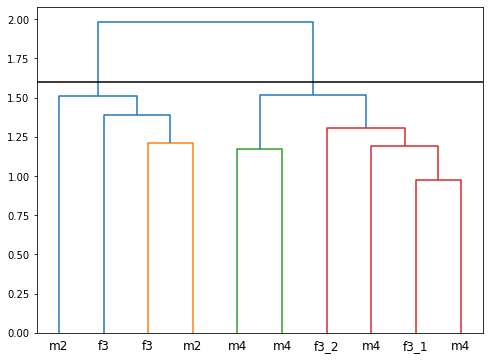

In [ ]:
## Dendogram

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')

In [ ]:
# Kolmogorov-Smirnov CLUSTERING

In [ ]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

In [ ]:
## K-S Matrix ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

In [ ]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

In [ ]:
## Dendogram

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')

## <b>Ch 6. Part 6 요약 및 정리</b>

### 강의 정리

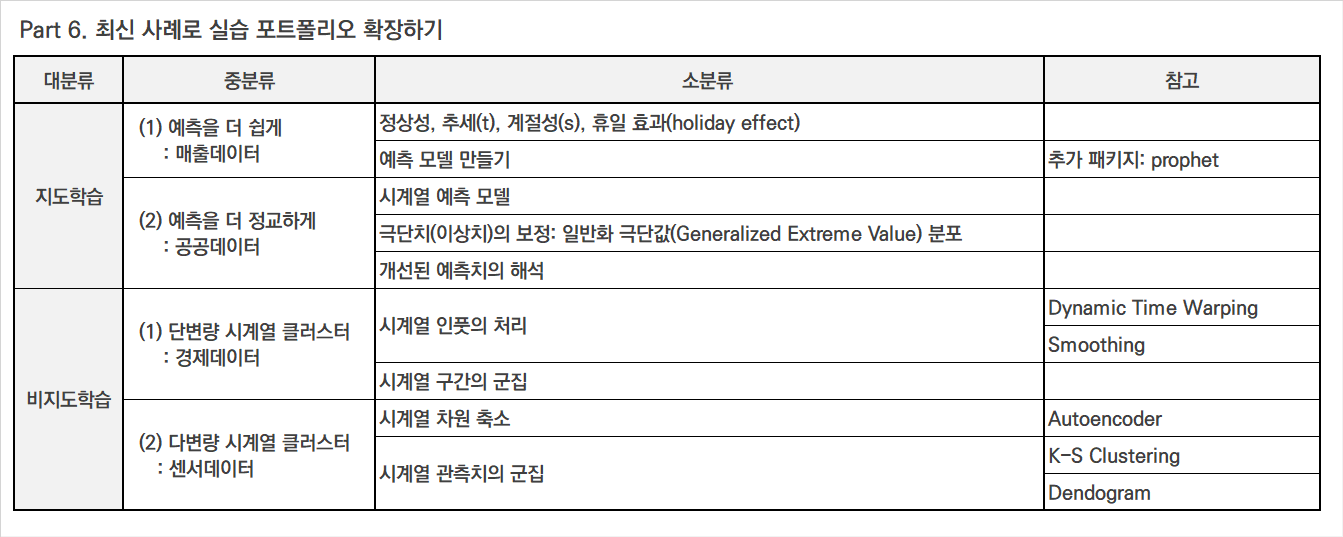

### 분석 포트폴리오 제작과 향후 학습 포인트

<b>실습 포트폴리오 길잡이</b>
- 남들과 비슷한 포인트, 남들보다 잘하는 포인트, 남들과 차별화되는 포인트
- '무엇'만큼 중요한 '왜?'
- '속도'만큼 중요한 '방향' (또는 '깊이')
- '지식'보다 중요한 '메타지식'

<b>데이터 소스 </b>

- UCI 머신러닝 리포지터리

  https://archive.ics.uci.edu/ml/index.php

- 통계청 국가통계포털(kosis)

  https://kosis.kr/index/index.do

- 한국은행 경제통계시스템(ecos) 
  
  https://ecos.bok.or.kr/

- 기상청 기상자료개방포털

  https://data.kma.go.kr/cmmn/main.do


<b>참고문헌</b>
- 이재길, R 프로그램에 기반한 시계열 자료 분석 
- 김명직, 장국현, 금융시계열분석, 경문사
- Yves Hilpisch, Python for Finance (번역서: 파이썬을 활용한 금융분석), O'Reilly
- Tsay, Analysis of Financial Time Series, 3rd Ed., Wiley